In [1]:
from tensorflow.python.keras.layers import deserialize
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import yaml
import skimage.measure
print('tensorflow version',tf.__version__)

tensorflow version 2.0.0


In [2]:
#Using GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#config = tf.compat.v1.ConfigProto(gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.3))
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [3]:
bin_size   = 2 #In this model, the data is already binned to size 5k from original spectra of size 25k. This is additional binning.
input_size= 5121//bin_size  
num_output= input_size 
num_class = 4

pos_enc  = False

In [4]:
start_time=time.time()
labels    = np.load('./../binned_data/binned_labels_100k.npy') #shape=(examples,labels of each spectra=5121)
end_time=time.time()
print('Time taken for loading mode data= %f s'%(end_time-start_time))

print('loaded mode data and its shape is (%d,%d)'%(labels.shape[0],labels.shape[1]))

labels = skimage.measure.block_reduce(labels,block_size=(1,bin_size),func=np.min)[:,:-1]
labels = labels.astype(np.int32)

print('Binned label data and its shape is (%d,%d)'%(labels.shape[0],labels.shape[1]))

Time taken for loading mode data= 0.885132 s
loaded mode data and its shape is (100000,5121)
Binned label data and its shape is (100000,2560)


In [5]:
start_time=time.time()
spectrum_data = np.load('./../binned_data/binned_data_100k.npy') #shape=(examples,length of spectrum)
end_time=time.time()
print('Time taken for loading spectrum data= %f s'%(end_time-start_time))

print('loaded spectrum data and its shape is (%d,%d)'%(spectrum_data.shape[0],spectrum_data.shape[1]))

spectrum_data = skimage.measure.block_reduce(spectrum_data,block_size=(1,bin_size),func=np.mean)[:,:-1]
spectrum_data = spectrum_data.reshape(spectrum_data.shape[0],spectrum_data.shape[1],1)

print('Binned spectra data and its shape is (%d,%d,1)'%(spectrum_data.shape[0],spectrum_data.shape[1]))

Time taken for loading spectrum data= 0.836789 s
loaded spectrum data and its shape is (100000,5121)
Binned spectra data and its shape is (100000,2560,1)


In [6]:
def positional_enc(X):

    X=np.squeeze(X)
    X = 2.*X
    X = X-1.
    pos_enc_sin = np.sin(np.arange(X.shape[1]))
    pos_enc_cos = np.cos(np.arange(X.shape[1]))


    X_pos    = np.empty((X.shape[0],X.shape[1],2),dtype=np.float32)
    X_pos[:,:,0] = X + pos_enc_sin
    X_pos[:,:,1] = X + pos_enc_sin

    return X_pos



if pos_enc ==True:
    spectrum_data = positional_enc(spectrum_data)    

#### Loading Model and the weights

In [7]:
#Path to the model
path = './../models/cnn_model_classification__lay_6__ksize_5__psize_3__dilrate_1__dropout_2__0.25__binsize__10__epochs_20__bs_128__train_95k__val_5k___generator_inp_size_2560_test_pos_enc_f_cw_normalized'
yaml_file = open('%s/model.yaml'%path, 'r') #Loading model from yaml file 
loaded_model_yaml = yaml_file.read()
yaml_file.close()
config = yaml.load(loaded_model_yaml,Loader=yaml.UnsafeLoader)
model = deserialize(config)
model.load_weights("%s/model.h5"%path) #Loading weights (either model.h5 or checkpoint-(num_epoch)-(val_loss).hdf5)
print("Loaded model from disk")

Loaded model from disk


In [8]:
example = 95021 #example to visualise or predict the labels
#predicted probability array of all outputs
pred_prob = model.predict(spectrum_data[example,:].reshape(1,spectrum_data.shape[1],spectrum_data.shape[2]))
pred_prob = np.squeeze(np.array(pred_prob))
predictied_labels = np.argmax(pred_prob,axis=1)

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5]),
 <a list of 9 Text yticklabel objects>)

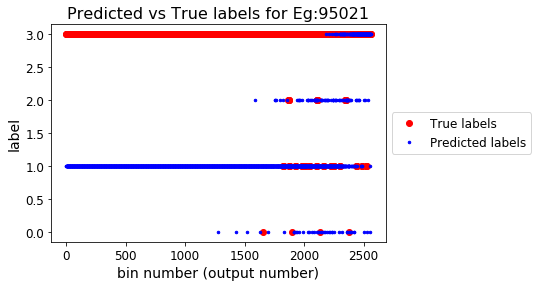

In [9]:
plt.plot(labels[example,:],'ro',label='True labels',ms=6)
plt.plot(predictied_labels,'bo',label='Predicted labels',ms=2.5)
plt.title('Predicted vs True labels for Eg:%d'%example,fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)
plt.xlabel('bin number (output number)',fontsize=14)
plt.ylabel('label',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

In [10]:
num_batchsize  = 128
num_train = 90000
num_val   = 5000
num_test  = 5000
evaluation_steps = 20


X_val = spectrum_data[num_train:num_train+num_val]
y_val = labels[num_train:num_train+num_val]
y_val = y_val.T # Reshaping labels array to (num_outputs,num_examples)

In [11]:
def valgenerator(X_val, y_val, num_batchsize):
    '''
    yields validation data with given num_batchsize. 
    It takes input as X_val and Y_val and yields
    batches to fit generator for validation.
    '''

    num_val = X_val.shape[0]

    while 1:
        for i in range(num_val//num_batchsize):
            z_val = y_val[:,i*num_batchsize:(i+1)*num_batchsize]
            print(i)
            yield X_val[i*num_batchsize:(i+1)*num_batchsize], list(z_val)


In [13]:
metrics_array = {}
loss_array = {}
for i in range(1,num_output+1):
    name = f'output_{i}'
    metrics_array[name] = 'sparse_categorical_accuracy'
    loss_array[name] = 'sparse_categorical_crossentropy'
    
start_time = time.time()
model.compile(loss=loss_array,optimizer=tf.keras.optimizers.Adam(),metrics=metrics_array)
end_time=time.time()
print('Time taken for compiling = %f s'%(end_time-start_time))

Time taken for compiling = 176.504710 s


In [14]:
start_time = time.time()
history = model.evaluate_generator(valgenerator(X_val, y_val, num_batchsize),steps=evaluation_steps)
end_time=time.time()
print('Time taken for evaluation = %f s'%(end_time-start_time))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
Time taken for evaluation = 315.894712 s


In [15]:
validation_loss = history[0]
print('validation loss = ',validation_loss)

average_accuracy=  np.mean(np.array(history)[-spectrum_data.shape[1]:])
print('average accuracy of outputs= ',average_accuracy)


validation loss =  4432.625561523438
average accuracy of outputs=  0.11379516619126662
